<a href="https://colab.research.google.com/github/Phosics/ReinforcementLearningFinal/blob/main/FinalAssignmentItzikTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - DEEP Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gymnasium
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
!pip install minigrid
!wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4


## Imports

In [ ]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [ ]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Introduction

For this project, you will work with environments from the [MiniGrid](https://minigrid.farama.org) framework. MiniGrid is designed to test and benchmark reinforcement learning algorithms, offering a diverse range of tasks with varying levels of complexity.

MiniGrid environments are built around the concept of a partially observable, grid-based world where an agent operates to achieve predefined objectives.

## **MultiRoom Environment**

You will work with the **MultiRoom Environment** see docomentation [here](https://minigrid.farama.org/environments/minigrid/MultiRoomEnv/). MultiRoomEnv introduces a level of complexity beyond simple navigation tasks by requiring the agent to navigate through multiple connected rooms to reach a goal. This environment is an excellent testbed for reinforcement learning algorithms that require exploration, memory, and planning.



## Understanding the `done` and `truncated` Mechanisms in MultiRoomEnv

As you experienced in the MidTerm assignment, the **GYM** API returns multiple outputs from the **`step`** method. In the MultiRoomEnv environment, two key mechanisms, **`done`** and **`truncated`**, are used to signify the end of an episode. These mechanisms are essential for managing the flow of training and providing valuable feedback about the agent's performance.


### `done`
- The `done` flag is set to `True` when the agent successfully reaches the goal.
- It indicates the successful termination of the episode, meaning the agent has completed the task.
- Example scenario: The agent navigates through all the rooms and reaches the green goal square in the final room.

### `truncated`
- The `truncated` flag is used to terminate an episode when a predefined condition is met, such as exceeding the maximum number of steps allowed.
- It does not necessarily indicate success or failure, but rather ensures that episodes do not run indefinitely.
- Example scenario: The agent fails to reach the goal within the allowed number of steps, and the episode ends prematurely.

**Pay Attention!**

Each time the environment is reset, the configuration of the rooms is randomized. This variability should be carefully considered during training, as resetting the environment every time the `max_step` limit is reached can make it challenging for the agent to learn effectively.

Additionally, note that the `max_step` parameter is defined as the number of rooms multiplied by 20.


## Random Action Rendering

In [ ]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
video_filename = '/content/vid.mp4'
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=16) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 120


## Wrappers for Observations: ImgObsWrapper and RGBImgPartialObsWrapper

For this project, you will use two wrappers provided by MiniGrid: **ImgObsWrapper** and **RGBImgPartialObsWrapper**. These wrappers modify the agent's observations.

### ImgObsWrapper
- The **ImgObsWrapper** converts the observation from its default dictionary format into a single image array.
- By default, observations in MiniGrid are returned as a dictionary containing both image data and other optional keys (e.g., mission strings). This wrapper extracts only the image component for simplicity.

### RGBImgPartialObsWrapper
- This wrapper provides a **partial view of the environment**, but instead of limiting it to a fixed field of view, it shows the **entire visible content of the current room** from the agent's position to the walls in the direction the agent is facing.
- The observation dynamically updates as the agent moves or turns, allowing it to see the layout of the room but not beyond its walls or through closed doors.
- This introduces the challenge of **partial observability across multiple rooms**, as the agent must explore and navigate to new rooms to gather more information about the environment.





### Wrapper Usage
To apply a wrapper, you can modify your environment setup as follows:

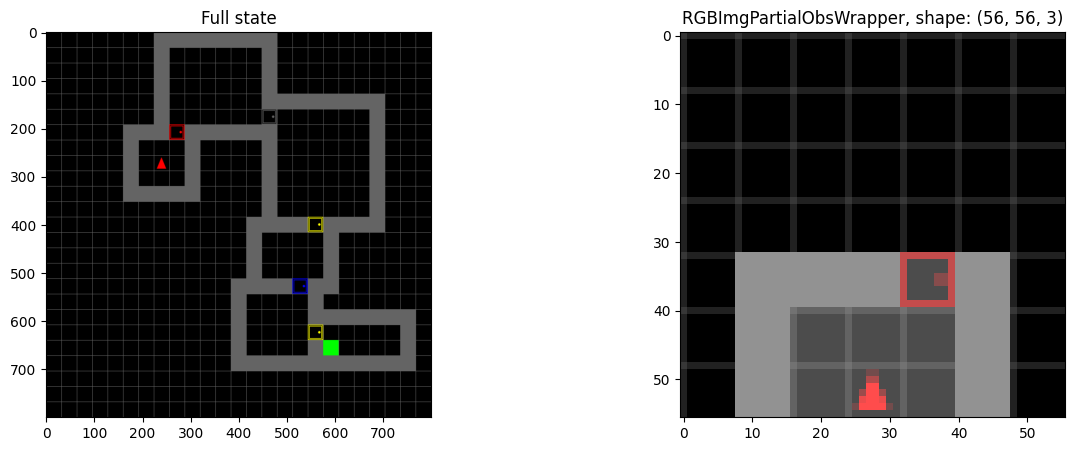

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments

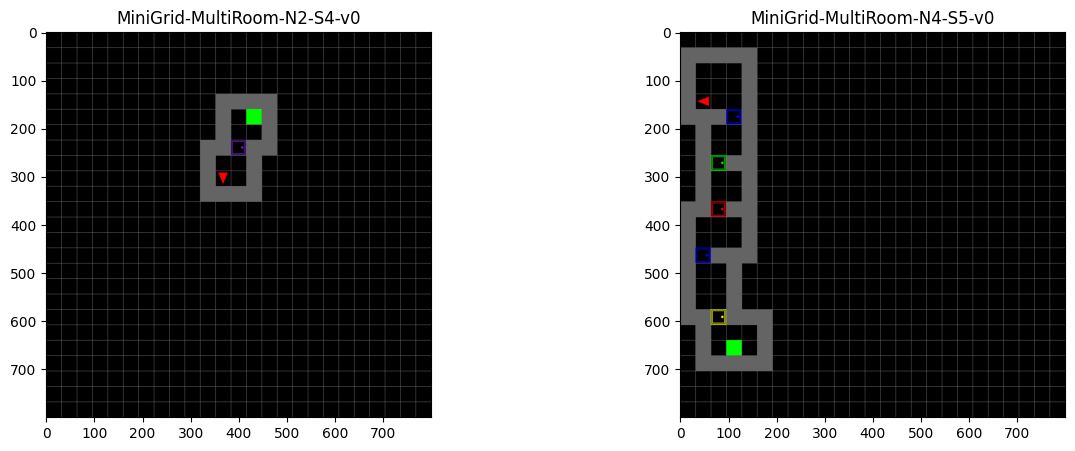

In [ ]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example

In [ ]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
video_filename = '/content/vid_partial.mp4'
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 120


## Exmple from our solution

In [ ]:
# Step 1: Correct download path
# Call the function
embed_mp4('MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi')


In [ ]:
# Set to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
##############################################
# Hyperparameters
##############################################

# Environment settings
ENV_NAME = "MiniGrid-MultiRoom-N2-S4-v0"
REPLAY_BUFFER_CAPACITY = 10000
BATCH_SIZE = 32
GAMMA = 0.99
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
TARGET_UPDATE_FREQ = 1000  # steps
EPSILON_START = 1.0
EPSILON_FINAL = 0.1
EPSILON_DECAY = 100000  # steps over which epsilon decays
# SEED = 42

In [ ]:
##############################################
# Reset Environment
##############################################
def env_reset(env, seed=None):
  if seed:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    return env.reset(seed=seed)
  else:
    return env.reset()

##############################################
# Preprocess
##############################################
def preprocess_state(state):
  """
  Convert the state (image) from H x W x C (uint8) to
  a float tensor with shape (C x H x W) normalized to [0,1].
  """
  state = np.array(state).astype(np.float32) / 255.0
  # Change from (H, W, C) to (C, H, W)
  return np.transpose(state, (2, 0, 1))

##############################################
# Epsilon Greedy Exploration Schedule
##############################################
def epsilon_by_frame(frame_idx):
  """
  Returns the epsilon value for the epsilon-greedy exploration strategy,
  decaying exponentially from EPSILON_START to EPSILON_FINAL.
  """
  return EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * frame_idx / EPSILON_DECAY)

##############################################
# Select Action
##############################################
def select_action(env, frame_idx, q_network, state_tensor):
  # Epsilon-greedy action selection.
  epsilon = epsilon_by_frame(frame_idx)

  if random.random() < epsilon:
    return env.action_space.sample()
  else:
    with torch.no_grad():
      q_vals = q_network.forward(state_tensor)
      return q_vals.argmax(1).item()

##############################################
# Custom Reward
##############################################
DOOR_OPEN_REWARD = 0.5
DOOR_CLOSE_PENALTY = -0.5     # Negative reward for closing an open door
DOOR_VIEW_REWARD = 0.02        # Reward for viewing a door in the agent's partial observation
INVALID_TOGGLE_PENALTY = -0.2 # Penalty for toggling when not in front of a door
REDUNDANT_TOGGLE_PENALTY = -0.1  # Penalty for toggling the same door consecutively
STEP_PENALTY = -0.01

def custom_reward(env, action, reward, done, truncated):
    """
    Computes the reward for a step in the MultiRoomEnv environment, incorporating:
      - A bonus for seeing a door in the visible area.
      - A reward for correctly toggling a door (opening a closed door or closing an open door).
      - A penalty for toggling a non-door cell.
      - A penalty for toggling the same door repeatedly.

    Parameters:
        env: The environment instance, which is assumed to provide:
             - env.agent_pos: (x,y) tuple for the agent’s current position.
             - env.grid: The underlying grid.
             - env.agent_dir: The agent’s current facing direction (0=right, 1=down, 2=left, 3=up).
             - env.actions: A namespace containing available actions (e.g. toggle).
             - env.in_view(x, y): Helper method returning True if a cell is visible.
             - Optionally, an attribute `last_toggled_door` for tracking door interactions.
        action: The action taken by the agent on this step.
        reward: The reward passed in from the base environment (unused here).
        done: Boolean indicating if the episode has finished.
        truncated: Boolean indicating if the episode was truncated.

    Returns:
        float: The computed reward for the step.
    """
    env = env.unwrapped
    total_reward = 0.0

    # Check for goal achievement.
    if done and not truncated:
        return total_reward

    # --- Check for door view bonus (Check 1) ---
    door_viewed = False
    # Iterate over grid cells to see if any door is visible in the agent's partial view.
    for x in range(env.grid.width):
        for y in range(env.grid.height):
            if env.in_view(x, y):
                cell = env.grid.get(x, y)
                if cell is not None and getattr(cell, "type", None) == "door":
                    door_viewed = True
                    break
        if door_viewed:
            break
    if door_viewed:
        total_reward += DOOR_VIEW_REWARD

    # --- Check for toggle action ---
    if action == env.actions.toggle:
        # Compute the coordinates of the cell in front.
        dx, dy = 0, 0
        if env.agent_dir == 0:
            dx = 1
        elif env.agent_dir == 1:
            dy = 1
        elif env.agent_dir == 2:
            dx = -1
        elif env.agent_dir == 3:
            dy = -1
        front_x = env.agent_pos[0] + dx
        front_y = env.agent_pos[1] + dy

        front_cell = env.grid.get(front_x, front_y)
        # --- Check if the cell in front is a door ---
        if front_cell is not None and getattr(front_cell, "type", None) == "door":
            # --- Redundant Toggle Prevention (Check 4) ---
            if hasattr(env, "last_toggled_door") and env.last_toggled_door == (front_x, front_y):
                total_reward += REDUNDANT_TOGGLE_PENALTY
            else:
                # Update last toggled door.
                env.last_toggled_door = (front_x, front_y)
                # Reward or penalize based on the door's current state.
                if front_cell.is_open:
                    total_reward += DOOR_CLOSE_PENALTY
                else:
                    total_reward += DOOR_OPEN_REWARD
        else:
            # --- Invalid Toggle Action Penalty (Check 2) ---
            total_reward += INVALID_TOGGLE_PENALTY

    prev_dist = env.compute_distance_to_goal(env.agent_pos)
    new_dist = env.compute_distance_to_goal(env.agent_pos)
    total_reward += (prev_dist - new_dist) * 0.05  # Reward for getting closer

    total_reward += STEP_PENALTY

    return total_reward

# DQN

In [ ]:
##############################################
# Define the Q-Network (using PyTorch)
##############################################
class DuelingDQN(nn.Module):
  def __init__(self, input_shape, num_actions):
    """
    A dueling convolutional neural network that maps image observations to Q-values.
    """
    super(DuelingDQN, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Flatten()
    )

    # Determine the size of the output from the conv layers
    with torch.no_grad():
        dummy_input = torch.zeros(1, *input_shape)
        conv_out_size = self.conv(dummy_input).shape[1]

    # Value Stream
    self.value_stream = nn.Sequential(
        nn.Linear(conv_out_size, 128),
        nn.ReLU(),
        nn.Linear(128, 1)  # Outputs a single state-value estimate
    )

    # Advantage Stream
    self.advantage_stream = nn.Sequential(
        nn.Linear(conv_out_size, 128),
        nn.ReLU(),
        nn.Linear(128, num_actions)  # Outputs advantage estimates for each action
    )

  def forward(self, x):
    x = x.float() / 255.0  # Normalize pixel values
    conv_out = self.conv(x)

    value = self.value_stream(conv_out)
    advantage = self.advantage_stream(conv_out)

    # Combine value and advantage streams to get Q-values
    q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
    return q_values

##############################################
# Experience Replay Buffer
##############################################
class ReplayBuffer:
  def __init__(self, capacity):
    self.capacity = capacity
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    """
    Save a transition.
    """
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    """
    Sample a batch of transitions.
    """
    batch = random.sample(self.buffer, batch_size)
    # Transpose the batch (list of tuples) into tuples of lists.
    states, actions, rewards, next_states, dones = zip(*batch)

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

  def __len__(self):
    return len(self.buffer)

def plot_episode_rewards(number_of_rooms, episode_rewards, successful_episodes):
    """
    Plots the episode rewards over training and prints the number of successful episodes.

    Args:
        episode_rewards (list): List of total rewards per episode.
    """
    num_episodes = len(episode_rewards)

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label="Episode Reward For " + str(number_of_rooms) + " rooms", alpha=0.7)
    plt.axhline(y=0, color="r", linestyle="--", label="Success Threshold (0 reward)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode Rewards Over Training")
    plt.legend()
    plt.grid()

    # Show stats
    print(f"Total Episodes: {num_episodes}")
    print(f"Successful Episodes: {successful_episodes}")

    plt.show()  # Display the plot

In [ ]:
##############################################
# Main Training Loop
##############################################

def train(env, q_network, target_network, optimizer, seed=None):
  replay_buffer = ReplayBuffer(REPLAY_BUFFER_CAPACITY)

  episode_rewards = []
  frame_idx = 0
  losses = []
  finish_counter = 0
  max_reward = 0
  best_avg_reward = 0

  for episode in range(1, NUM_EPISODES + 1):
    state, _ = env_reset(env)
    state = preprocess_state(state)
    episode_reward = 0
    done = False

    while not done:
      frame_idx += 1
      # Prepare the current state tensor.
      state_tensor = torch.from_numpy(state).to(device)
      state_tensor = state_tensor.unsqueeze(0)

      # Epsilon-greedy action selection.
      action = select_action(env, frame_idx, q_network, state_tensor)

      # Take the action in the environment.
      next_state, reward, done, truncated, _ = env.step(action)
      episode_reward += custom_reward(env, action, reward, done, truncated)
      next_state_proc = preprocess_state(next_state)

      # Save the transition in the replay buffer.
      replay_buffer.push(state, action, reward, next_state_proc, done)
      state = next_state_proc

      # Update the Q-network once enough samples are available.
      if len(replay_buffer) > BATCH_SIZE:
        states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

        # Convert the mini-batch to PyTorch tensors.
        states = torch.tensor(states, dtype=torch.uint8).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.uint8).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Compute Q-values for current states.
        q_values = q_network.forward(states)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q-values using the target network.
        with torch.no_grad():
          next_q_values = target_network(next_states)
          next_q_value = next_q_values.max(1)[0]
          target = rewards + GAMMA * next_q_value * (1 - dones)

        # Compute the loss (Mean Squared Error).
        loss = nn.MSELoss()(q_value, target)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the target network periodically.
        if frame_idx % TARGET_UPDATE_FREQ == 0:
          target_network.load_state_dict(q_network.state_dict())

    if done and not truncated:
      finish_counter += 1

    episode_rewards.append(episode_reward)
    if episode % 10 == 0:
      avg_reward = np.mean(episode_rewards[-10:])
      avg_loss = np.mean(losses[-100:]) if losses else 0
      epsilon_val = epsilon_by_frame(frame_idx)

      if avg_reward > best_avg_reward:
        best_avg_reward = avg_reward
        print("Saving parameters...")
        torch.save(q_network.state_dict(), 'best_model.pth')

      print(f"Episode: {episode}, Frame: {frame_idx}, Epsilon: {epsilon_val}, Avg Reward (last 10): {avg_reward:.2f}, Loss: {avg_loss:.4f}, Finished: {finish_counter}")

  env.close()

  return episode_rewards, finish_counter

In [ ]:
##############################################
# Hyperparameters
##############################################

# Environment settings
ENV_NAME_2 = "MiniGrid-MultiRoom-N2-S4-v0"
ENV_NAME_4 = "MiniGrid-MultiRoom-N4-S5-v0"
ENV_NAME_6 = "MiniGrid-MultiRoom-N6-v0"
REPLAY_BUFFER_CAPACITY = 10000
BATCH_SIZE = 32
GAMMA = 0.99
LEARNING_RATE = 1e-4
NUM_EPISODES = 500
TARGET_UPDATE_FREQ = 1000  # steps
EPSILON_START = 1.0
EPSILON_FINAL = 0.1
EPSILON_DECAY = 500000  # steps over which epsilon decays
# SEED = 42

# Create the environment
env = gymnasium.make(ENV_NAME_2, render_mode=render_mode, highlight=highlight)

# Wrap to get a partial (RGB) observation and then extract the image
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

# Reset the environment
state, _ = env_reset(env)
state = preprocess_state(state)

# Get initial observation and derive input dimensions.
input_shape = state.shape
num_actions = env.action_space.n

# Initialize the Q-network and target network.
q_network = DuelingDQN(input_shape, num_actions).to(device)
target_network = DuelingDQN(input_shape, num_actions).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()  # Target network is only used for inference.

optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)

episode_rewards, finish_counter = train(env, q_network, target_network, optimizer)

plot_episode_rewards(2, episode_rewards, finish_counter)

# NUM_EPISODES = 50

# # Create the environment
# env = gymnasium.make(ENV_NAME_4, render_mode=render_mode, highlight=highlight)

# # Wrap to get a partial (RGB) observation and then extract the image
# env = RGBImgPartialObsWrapper(env)
# env = ImgObsWrapper(env)

# train(env, q_network, target_network, optimizer)

# NUM_EPISODES = 20

# # Create the environment
# env = gymnasium.make(ENV_NAME_6, render_mode=render_mode, highlight=highlight)

# # Wrap to get a partial (RGB) observation and then extract the image
# env = RGBImgPartialObsWrapper(env)
# env = ImgObsWrapper(env)

# train(env, q_network, target_network, optimizer)

Episode: 10, Frame: 7444, Epsilon: 0.9867000504872359, Avg Reward (last 10): -12.67, Loss: 2.5871, Finished: 0
Episode: 20, Frame: 15766, Epsilon: 0.9720639543153262, Avg Reward (last 10): -13.86, Loss: 0.0009, Finished: 0
Episode: 30, Frame: 19155, Epsilon: 0.9661730915197905, Avg Reward (last 10): -5.93, Loss: 0.4509, Finished: 1
Episode: 40, Frame: 24929, Epsilon: 0.9562280578027679, Avg Reward (last 10): -10.15, Loss: 0.9182, Finished: 1
Episode: 50, Frame: 31960, Epsilon: 0.9442720386391492, Avg Reward (last 10): -10.08, Loss: 0.4183, Finished: 1
Episode: 60, Frame: 37648, Epsilon: 0.9347220234056588, Avg Reward (last 10): -10.33, Loss: 1.2609, Finished: 1
Episode: 70, Frame: 44030, Epsilon: 0.924135339447153, Avg Reward (last 10): -9.82, Loss: 1.3278, Finished: 1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-696a217ac858>", line 43, in <cell line: 0>
    train(env, q_network, target_network, optimizer)
  File "<ipython-input-9-04886b68779f>", line 32, in train
    episode_reward += custom_reward(env, action, reward, done, truncated)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-11-2e03805a3650>", line None, in custom_reward
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of

# PPO

In [ ]:
##############################################
# Define the Actor-Critic Network
##############################################

class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions):
        """
        A convolutional actor-critic network for processing image observations.
        """
        super(ActorCritic, self).__init__()
        # Input shape is expected to be (channels, height, width)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        # Compute the size of the flattened conv output to build the fully connected layers.
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out_size = self.conv(dummy_input).shape[1]

        self.fc_actor = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        self.fc_critic = nn.Sequential(
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Normalize pixel values to [0,1]
        x = x.float() / 255.0
        x = self.conv(x)
        logits = self.fc_actor(x)
        value = self.fc_critic(x)
        return logits, value

    def act(self, obs):
        """
        Given an observation, select an action and return action details.
        """
        logits, value = self.forward(obs)
        # Create a categorical distribution over actions
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), value

    def evaluate_actions(self, obs, actions):
        """
        Evaluate given actions (for PPO loss computation).
        """
        logits, value = self.forward(obs)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action_log_probs = dist.log_prob(actions)
        dist_entropy = dist.entropy()
        return action_log_probs, torch.squeeze(value), dist_entropy

##############################################
# Helper: Compute GAE
##############################################

def compute_gae(rewards, values, dones, gamma, lam):
    """
    Compute Generalized Advantage Estimation (GAE)
    """
    advantages = []
    gae = 0
    # Append a dummy value for the next state.
    values = values + [0]
    for step in reversed(range(len(rewards))):
        mask = 1.0 - dones[step]
        delta = rewards[step] + gamma * values[step + 1] * mask - values[step]
        gae = delta + gamma * lam * mask * gae
        advantages.insert(0, gae)
    returns = [adv + val for adv, val in zip(advantages, values[:-1])]
    return advantages, returns

In [ ]:
##############################################
# PPO Hyperparameters
##############################################

ppo_epochs = 4           # Number of PPO epochs per update
mini_batch_size = 64     # Size of mini-batches for optimization
clip_epsilon = 0.2       # PPO clipping epsilon
gamma = 0.99             # Discount factor
gae_lambda = 0.95        # GAE lambda
learning_rate = 2.5e-4   # Learning rate for optimizer
num_steps = 128          # Number of steps to collect per update
total_updates = 10000    # Total number of updates

In [ ]:
##############################################
# Main Training Loop
##############################################

def train():
    # Create the MiniGrid MultiRoom environment.
    # (Change the env name as needed. For example: "MiniGrid-MultiRoom-N2-v0")
    env = gym.make("MiniGrid-MultiRoom-N2-v0")

    # Choose one of the wrappers:
    # Use the ImgObsWrapper for fully observable image observations:
    env = ImgObsWrapper(env)
    # Or, to use partial RGB image observations, uncomment the next line:
    # env = RGBImgPartialObsWrapper(env)

    # Seed for reproducibility
    env.seed(42)
    torch.manual_seed(42)
    np.random.seed(42)

    # Get observation and action space information.
    obs = env.reset()
    # The observation from the wrappers is an image: shape (height, width, channels)
    # PyTorch expects (channels, height, width)
    obs = np.transpose(obs, (2, 0, 1))
    input_shape = obs.shape  # e.g. (3, 84, 84) depending on the wrapper/env.
    num_actions = env.action_space.n

    # Initialize our actor-critic network and optimizer.
    model = ActorCritic(input_shape, num_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Tracking rewards for display.
    episode_rewards = deque(maxlen=10)
    total_episode_reward = 0
    episode = 0

    # Start main training loop.
    obs = env.reset()
    obs = np.transpose(obs, (2, 0, 1))
    obs = torch.tensor(obs, dtype=torch.uint8).unsqueeze(0).to(device)

    for update in range(total_updates):
        observations = []
        actions = []
        log_probs = []
        rewards = []
        dones = []
        values = []

        # Collect trajectories for num_steps time steps.
        for step in range(num_steps):
            action, log_prob, value = model.act(obs)
            observations.append(obs)
            actions.append(action)
            log_probs.append(log_prob)
            values.append(value.item())

            # Step the environment
            next_obs, reward, done, info = env.step(action)
            total_episode_reward += reward

            rewards.append(reward)
            dones.append(done)

            if done:
                episode_rewards.append(total_episode_reward)
                total_episode_reward = 0
                episode += 1
                next_obs = env.reset()

            next_obs = np.transpose(next_obs, (2, 0, 1))
            obs = torch.tensor(next_obs, dtype=torch.uint8).unsqueeze(0).to(device)

        # Compute advantages and returns.
        advantages, returns = compute_gae(rewards, values, dones, gamma, gae_lambda)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        actions = torch.tensor(actions).to(device)
        old_log_probs = torch.stack(log_probs).detach().to(device)

        # Flatten collected observations (they are stored as [T, 1, C, H, W]).
        observations = torch.cat(observations, dim=0).float()  # Shape: (num_steps, C, H, W)

        # PPO update: iterate multiple times over the batch.
        batch_size = num_steps
        indices = np.arange(batch_size)
        for epoch in range(ppo_epochs):
            np.random.shuffle(indices)
            for start in range(0, batch_size, mini_batch_size):
                end = start + mini_batch_size
                mb_idx = indices[start:end]

                mb_obs = observations[mb_idx]
                mb_actions = actions[mb_idx]
                mb_old_log_probs = old_log_probs[mb_idx]
                mb_returns = returns[mb_idx]
                mb_advantages = advantages[mb_idx]

                # Normalize advantages (optional but often helps training).
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                # Evaluate current policy on the mini-batch.
                new_log_probs, values_est, entropy = model.evaluate_actions(mb_obs, mb_actions)
                ratio = torch.exp(new_log_probs - mb_old_log_probs)

                # Compute surrogate PPO loss.
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value loss (using Mean Squared Error).
                value_loss = nn.MSELoss()(values_est, mb_returns)

                # Total loss with an entropy bonus.
                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy.mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Display progress every 100 updates.
        if update % 100 == 0:
            avg_reward = np.mean(episode_rewards) if episode_rewards else 0
            print(f"Update {update}, Episode {episode}, Avg Reward (last 10): {avg_reward:.2f}")

    env.close()